In [1]:
import numpy as np
import scipy.stats as stats
import scipy.linalg as la
import matplotlib.pyplot as plt

In [2]:
round_precision = 6

In [3]:
M = 15
epsilon = 0.9 # Must be [0, 1)
V = V_prime = 1

In [4]:
i = np.arange(start=1, stop=M+1)
alpha_i = (M + 1 - i)/M
p_i = i/M # These are the initial p_i values (channel quality parameters)
q_i = epsilon*p_i/M

Scenario: p is changing over time as a random walk process (in which p is bounded as (0,1])

New variations to look at:
- Different moving average techniques / estimation techniques
- Optimization horizon (relevant for all policies except MW)
- Volatility of probability traces (volatility parameter)

Variations also tested in Kadota 2019
- Importance/hardness of the throughput constraints (epsilon)
- Different values of V and V' (which are relevant to MW and DPP, respectively)
- Number of nodes (M)

Other possible variations (but might not be as important since they are not varied in Kadota 2019)
- Channel quality parameters (initial p_i values)
- Throughput constraints (q_i = epsilon * initial p_i / M)
- Node weights (alpha_i)

# Generate Probability Traces

In [5]:
K = 10000

In [6]:
# Generate M random walks
bernoulli_param = 0.5 # High value -> small frequent increases, large infrequent decreases; Low value -> small frequent decreases, large infrequent increases
volatility_param = 0.02 # How large the changes are (COMPARE RESULTS WITH DIFFERENT VALUES)

# Each Bernoulli RV is mean-shited so that its expected value is zero
bernoulli_rvs = volatility_param*(stats.bernoulli(p=bernoulli_param).rvs((M, K-1))-bernoulli_param)

p_i_k = np.zeros((M, K))
p_i_k[:, 0] = p_i
for slot in range(K-1):
    p_i_k[:, slot+1] = p_i_k[:, slot] + bernoulli_rvs[:, slot]

    # Enforce upper and lower bounds (0,1] (this is the feaasible set specified in Kadota 2019)
    p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] > 1, 1, p_i_k[:, slot+1])
    p_i_k[:, slot+1] = np.where(p_i_k[:, slot+1] < volatility_param, volatility_param, p_i_k[:, slot+1]) # smallest value above zero

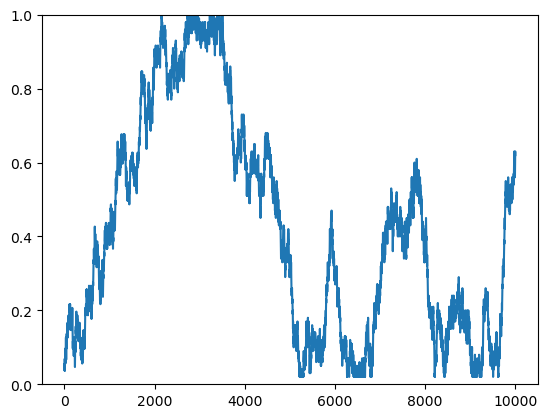

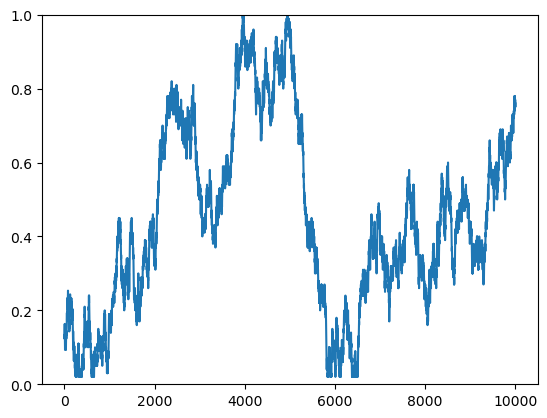

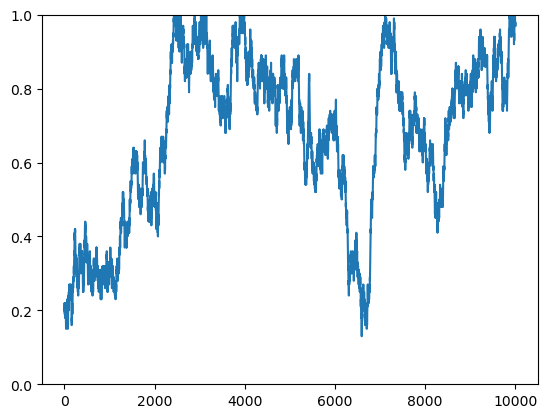

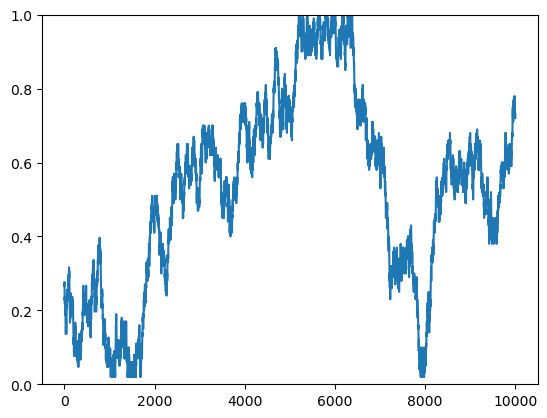

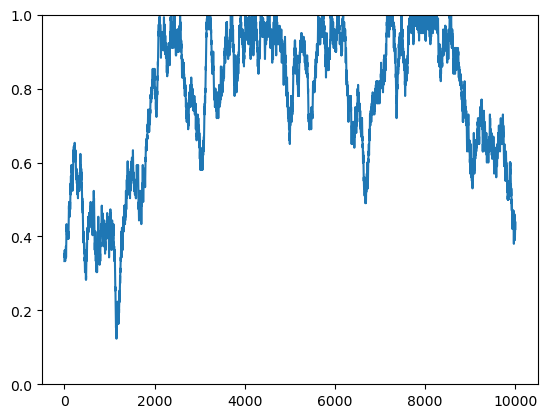

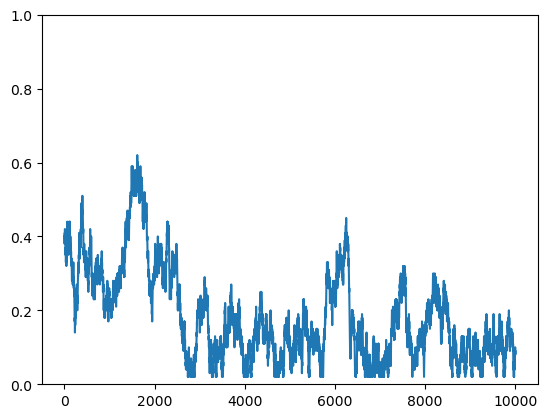

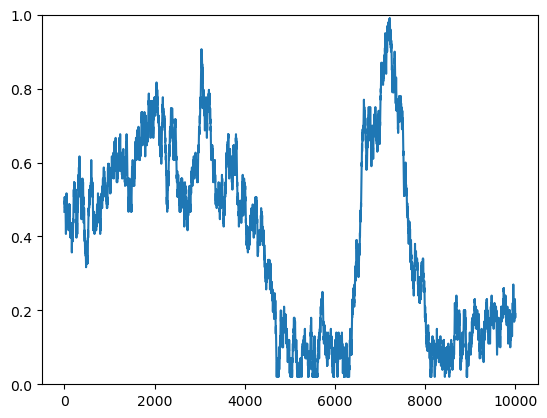

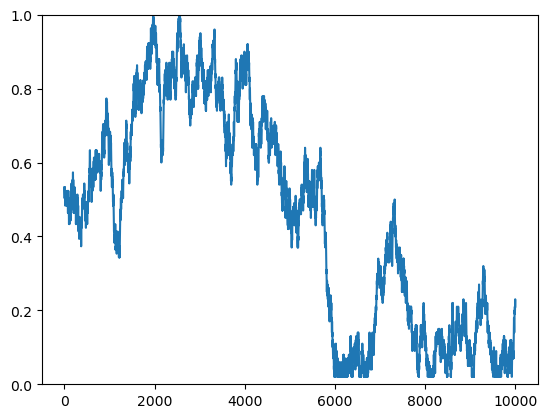

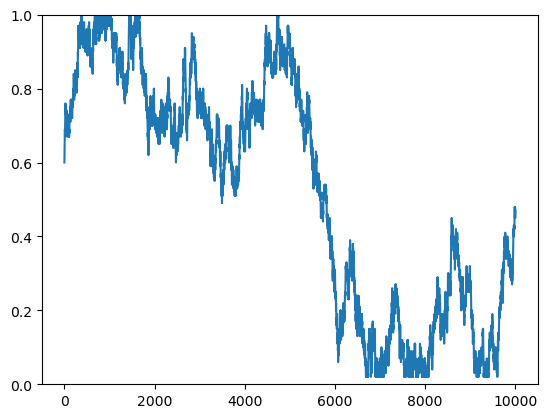

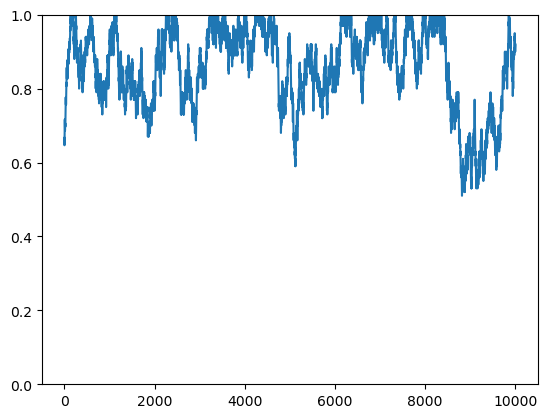

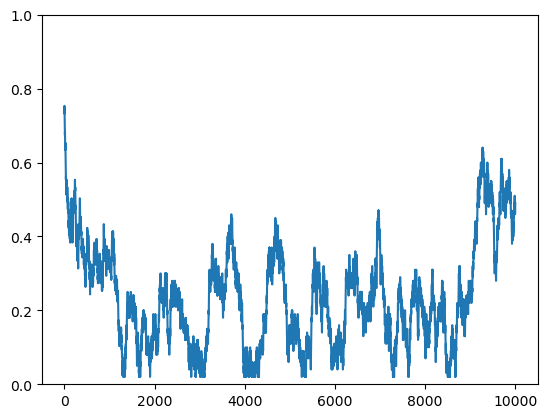

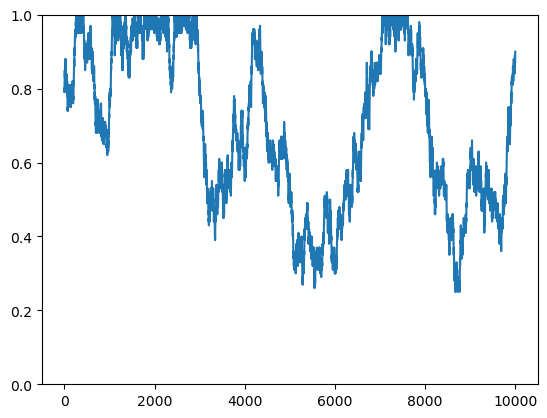

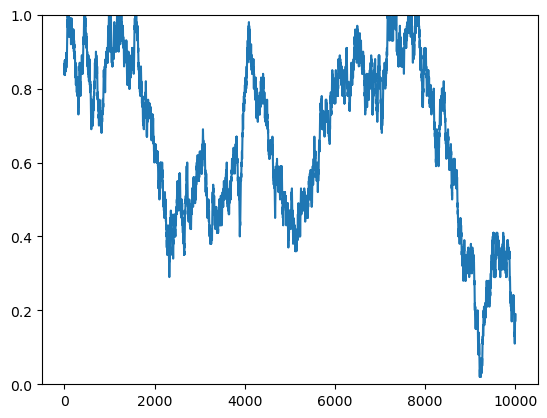

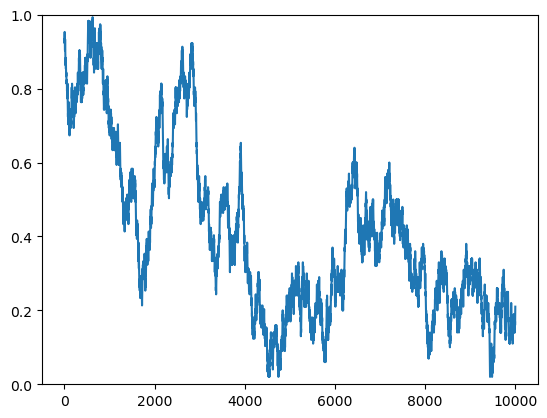

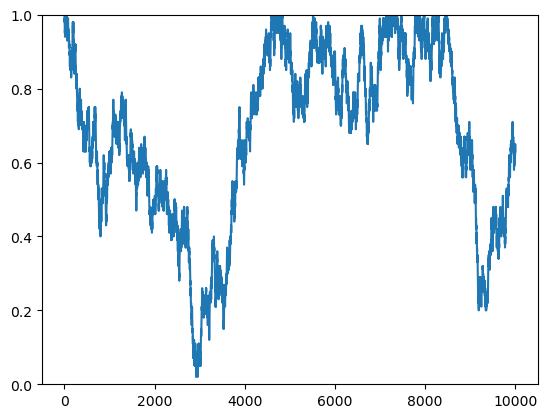

In [7]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.ylim([0,1])

# Scheduling Algorithm 1: Optimal Stationary Randomized Policy 

In [8]:
G = 100
K_opt = 500 # Each K_opt slots, the algorithm will repeat the optimization using the current estimates of p_i
zeta = 0.05 # Averaging parameter. Need to establish which value works best, or could test across different values

In [9]:
J_avg_exp = 0
x_max_norm = 0
p_i_est_avg = np.zeros((M,K))

# Repeat simulation over G samples
for z in range(G):
    # Initialize transmission matrix
    d_i_k = np.zeros((M,K))

    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Generate outcome matrix that indicate whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # Initialize estimates of p_i
    p_i_est = p_i#0.5*np.ones(M)

    # For each optimization horizon
    for opt_hor in range(int(K/K_opt)):
        # Perfect knowledge
        #p_i_est = p_i_k[:, opt_hor*K_opt]

        #print("Starting Optimization")
        # Throughput requirements for optimization
        tp_sum = np.sum(q_i/p_i_est)
        
        # Check whether q is a feasible set of minimum throughput requirements
        q_i_opt = q_i
        if tp_sum > 1:
            #print("Minimum throughput requirements are infeasible")
            # Best we can do is solve the optimization problem with lower throughput requirements
            q_i_opt /= tp_sum
        
        # Solve optimization
        gamma_i = alpha_i*p_i_est/(M*q_i_opt**2)
        gamma_test = np.max(gamma_i)
        mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
        S_test = np.sum(mu_i_test)

        #print(gamma_test)
        # Get close to the optimal value through successive division by 2 (This significantly speeds up optimization)
        while S_test < 1:
            gamma = gamma_test
            mu_i = mu_i_test
            S = S_test
            
            gamma_test /= 2
            mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
            S_test = np.sum(mu_i_test)
        #print(gamma)
        #print(gamma_test)
        # More exact optimization starting from value from previous loop
        while S < 1:
            gamma -= 0.1
            mu_i = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma) > 1, np.sqrt(gamma_i/gamma), 1)
            S = np.sum(mu_i)
        #print(gamma)

        #print(S)
        #print(mu_i)

        # Ensure that mu_i exactly add up to one
        mu_i = np.round(mu_i, round_precision)
        subt_idx = np.argmax(mu_i)
        mu_i[subt_idx] -= (np.sum(mu_i) - 1.0)
        #if np.round(np.sum(mu_i), 8) != 1:
        #    print(np.sum(mu_i))
        #    print(mu_i)
        #    print(tp_sum)
        #    print(S-1)
        #    print(subt_idx)
        #    print('\n')
        #print(np.sum(mu_i))
        #print(mu_i)
        #print('\n')
        #print("Finished Optimization")
        
        # Sample to determine which nodes will be scheduled in which slot (for all the slots in the opt horizon)
        i_k = stats.rv_discrete(a=1, b=M, values=(i, mu_i)).rvs(size=K_opt)

        # Loop over slots
        for k in range(K_opt):
            # Calculate transmission matrix that indiciates which node has an arrival in this slot
            i_sel_idx = i_k[k]-1
            arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
            d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful

            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]

            # Update estimate for the scheduled node
            p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est

    # Calculate max normalized throughput debt
    x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))

J_avg_exp /= (G*K*M)
x_max_norm /= G
p_i_est_avg /= G

In [10]:
J_avg_exp

24.872390288888727

In [11]:
x_max_norm

0.11059423804992653

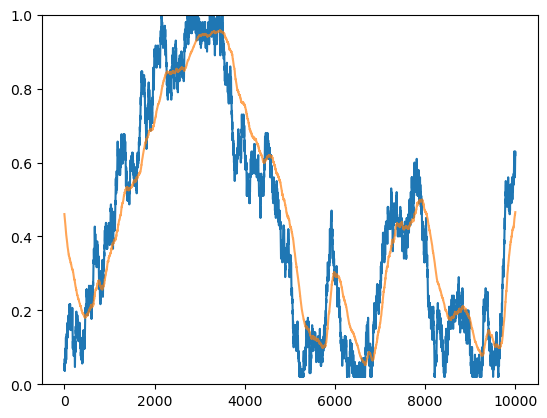

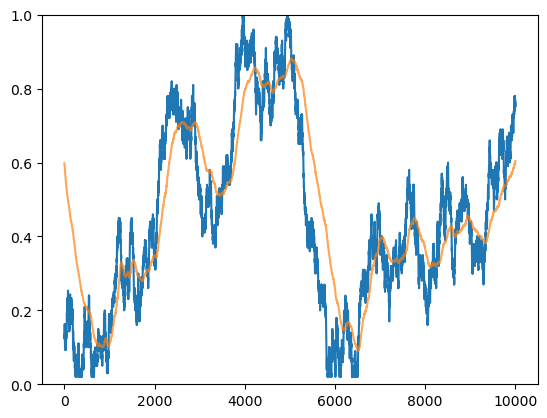

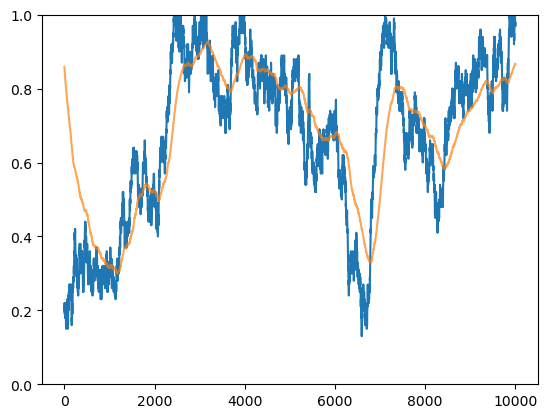

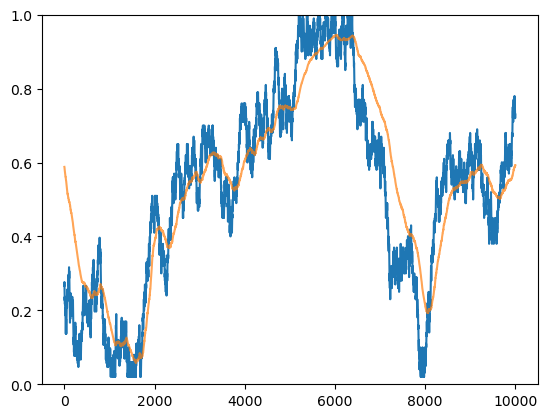

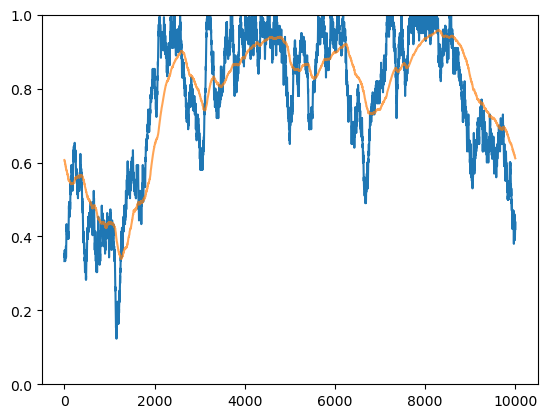

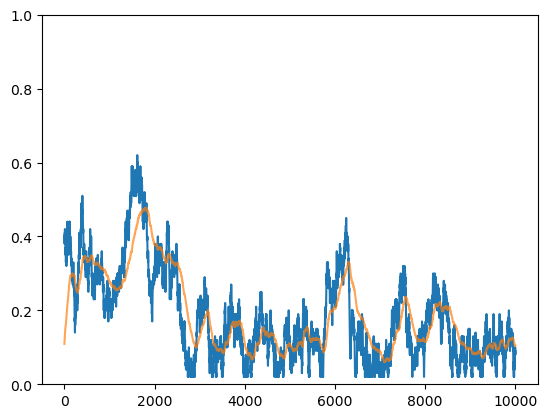

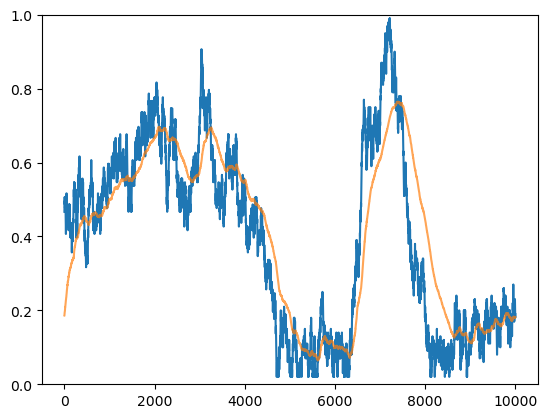

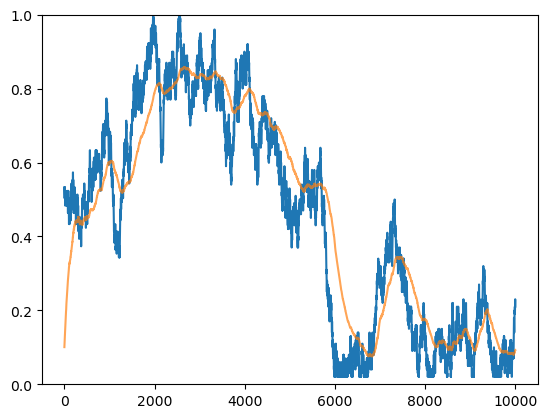

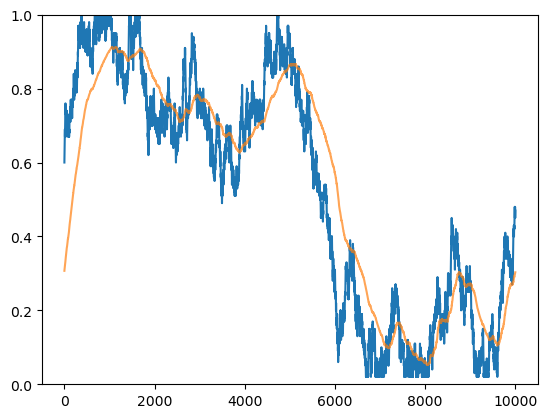

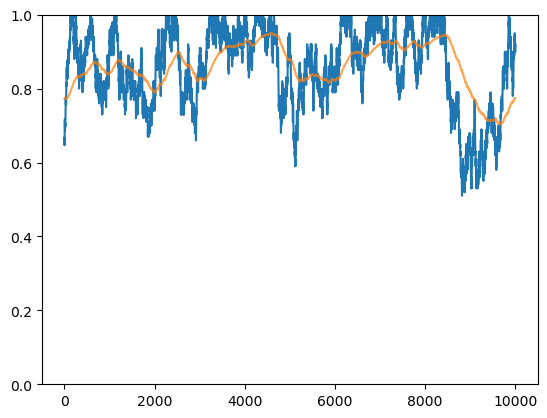

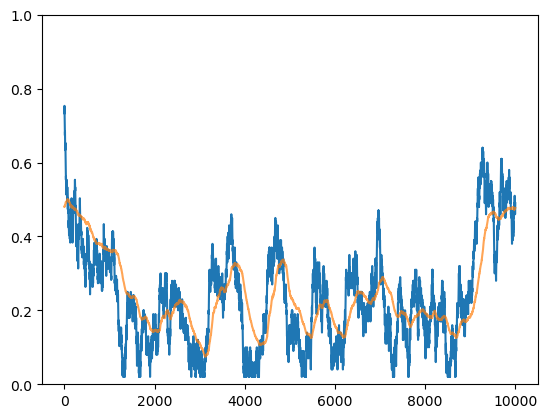

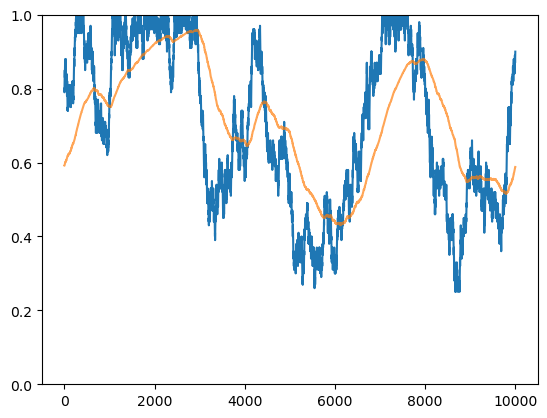

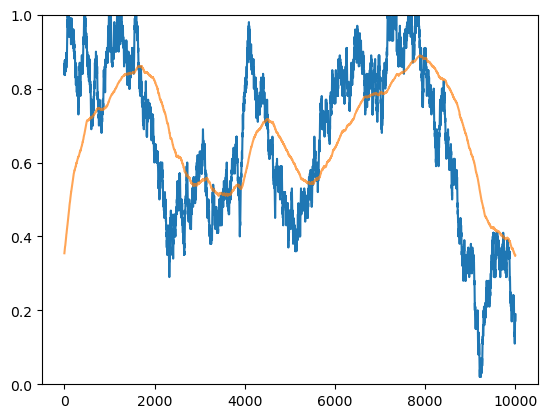

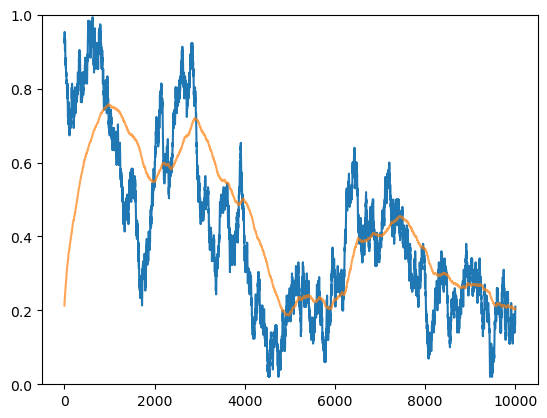

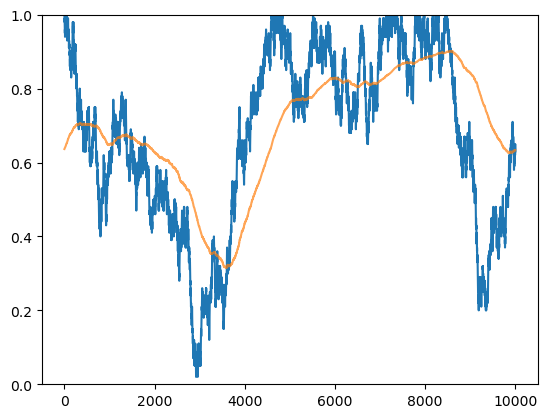

In [12]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7)
    plt.ylim([0,1])

# Scheduling Algorithm 2: Max-Weight Policy

In [13]:
# Simulation parameters
G = 100
zeta = 0.05 # Averaging parameter. Need to establish which value works best, or could test across different values

In [14]:
J_avg_exp = 0
x_max_norm = 0
p_i_est_avg = np.zeros((M,K))

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # Initialize estimates of p_i
    p_i_est = p_i#0.5*np.ones(M)
    
    # Loop over slots
    for k in range(K):
        # Select node according to policy
        W_i = (0.5*alpha_i*(h_i**2+2*h_i) + V*np.where(x_i > 0, x_i, 0))*p_i_est
        i_sel_idx = np.argmax(W_i)
        
        # Update transmission matrix based on whether transmission was successful or not
        arrival_successful = o_i_k[i_sel_idx, k]
        d_i_k[i_sel_idx, k] = arrival_successful

        # Calculate weighted sum AoI
        J_avg_exp += np.sum(alpha_i * h_i)
        
        # Update AoI and throughput debt vectors
        h_i += 1
        if arrival_successful: # if transmission was successful
            h_i[i_sel_idx] = 1
        x_i += q_i - d_i_k[:, k]

        # Update estimate for the scheduled node
        p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
        p_i_est_avg[:, k] += p_i_est

    # Calculate max normalized throughput debt
    x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
    #print(x_max_norm)
    
J_avg_exp /= (G*K*M)
x_max_norm /= G
p_i_est_avg /= G

In [15]:
J_avg_exp

14.149216164444534

In [16]:
x_max_norm

0.0

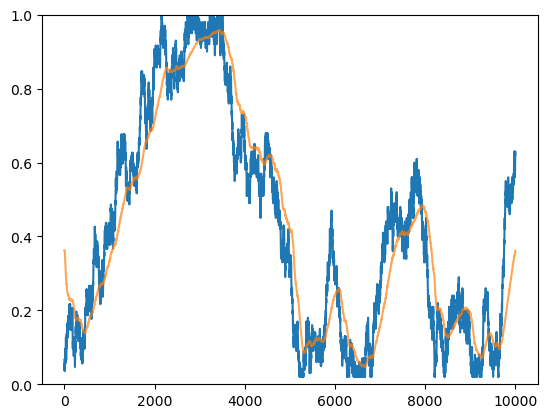

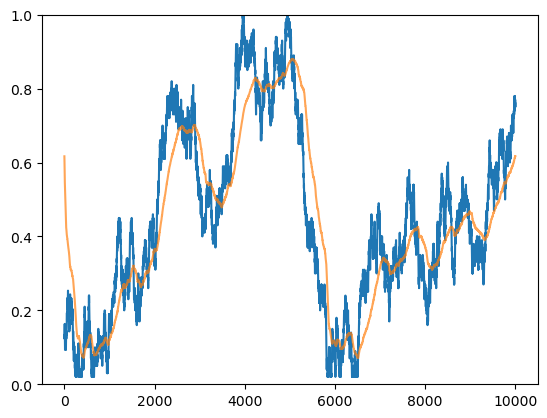

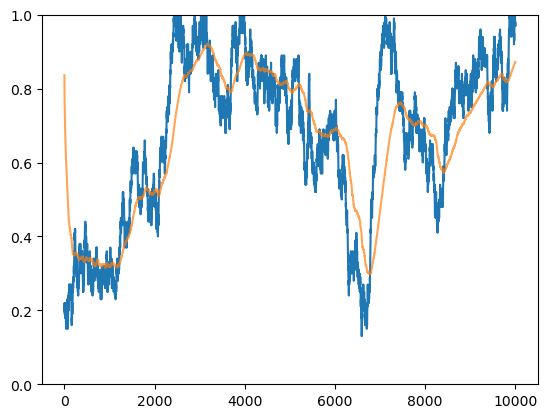

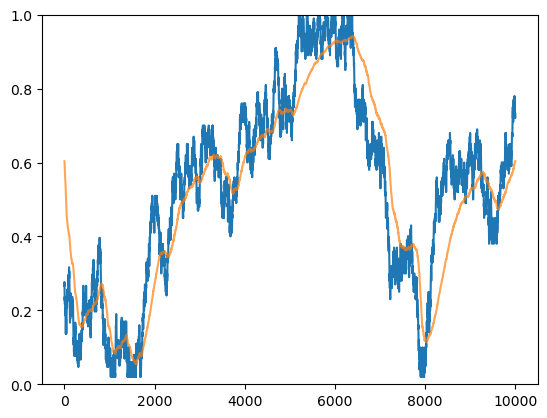

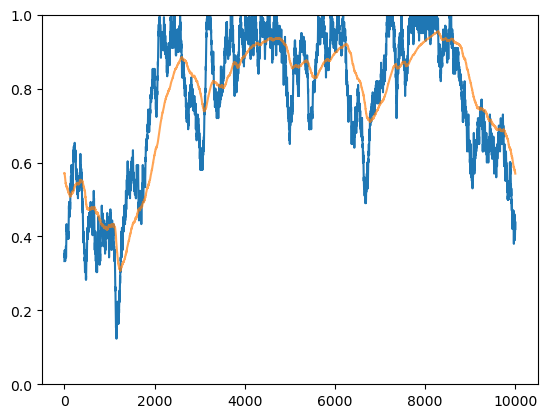

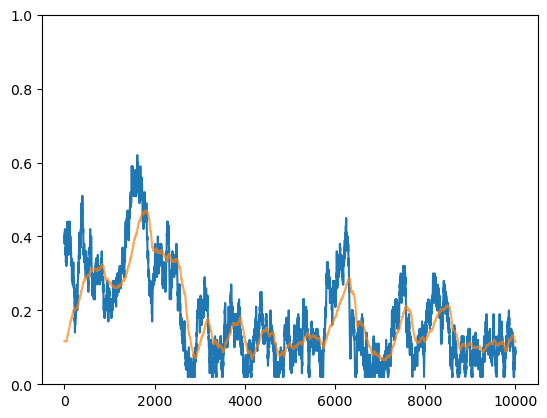

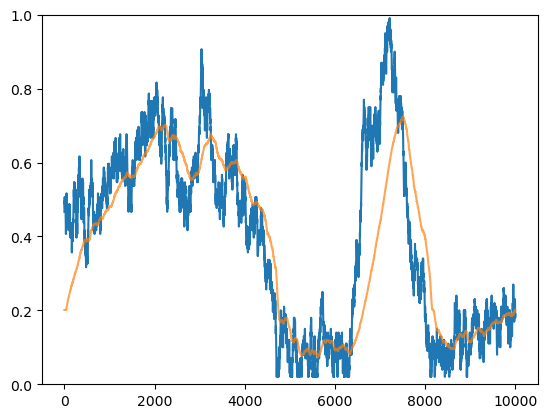

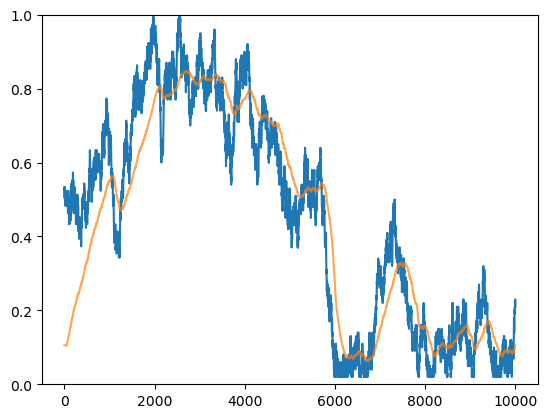

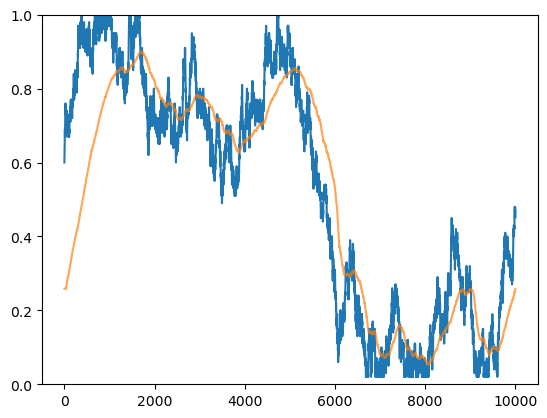

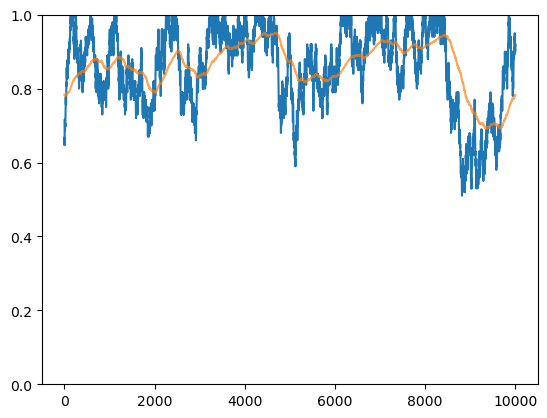

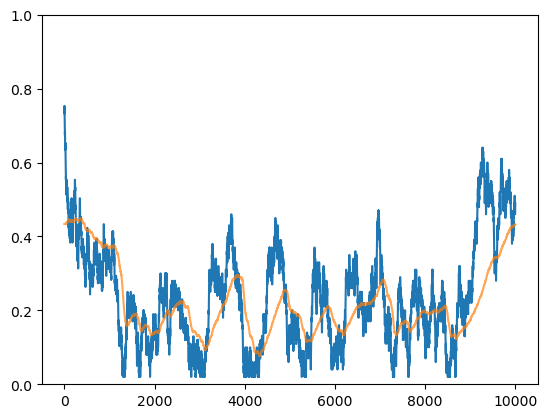

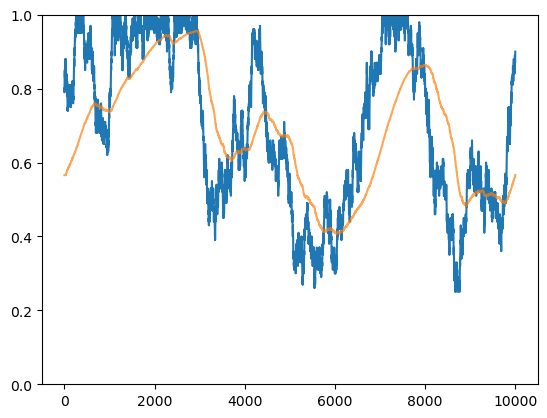

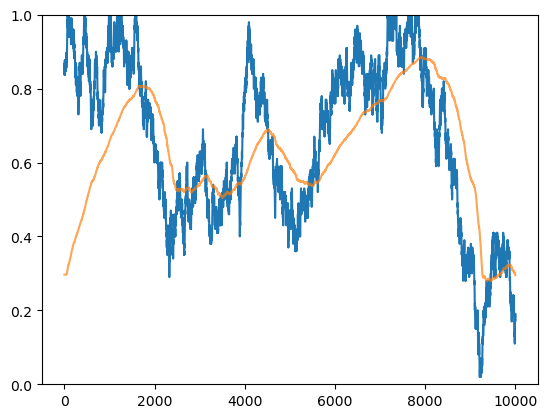

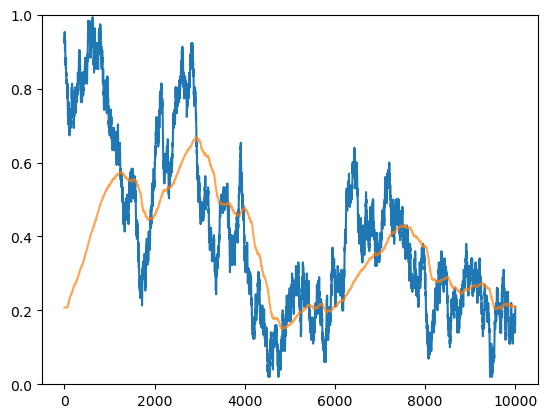

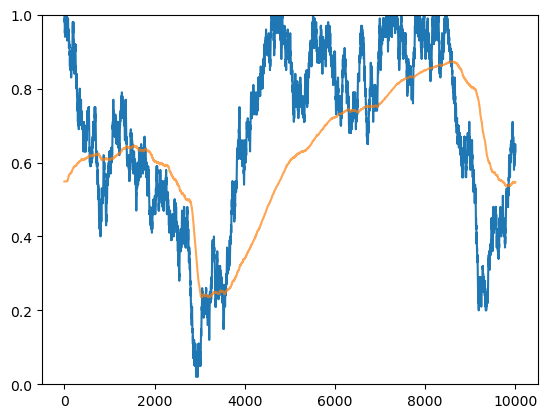

In [17]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7)
    plt.ylim([0,1])

# Scheduling Algorithm 3: Drift-Plus-Penalty Policy

In [18]:
# Simulation parameters
G = 100
K_opt = 500 # Each K_opt slots, the algorithm will repeat the optimization using the current estimates of p_i
zeta = 0.05 # Averaging parameter. Need to establish which value works best, or could test across different values

In [19]:
J_avg_exp = 0
x_max_norm = 0
p_i_est_avg = np.zeros((M,K))

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # Initialize estimates of p_i
    p_i_est = p_i#0.5*np.ones(M)

    # For each optimization horizon
    for opt_hor in range(int(K/K_opt)):
        # Throughput requirements for optimization
        tp_sum = np.sum(q_i/p_i_est)
        
        # Check whether q is a feasible set of minimum throughput requirements
        q_i_opt = q_i
        if tp_sum > 1:
            # Best we can do is solve the optimization problem with lower throughput requirements
            q_i_opt /= tp_sum
        
        # Solve optimization
        gamma_i = alpha_i*p_i_est/(M*q_i_opt**2)
        gamma_test = np.max(gamma_i)
        mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
        S_test = np.sum(mu_i_test)

        # Get close to the optimal value through successive division by 2 (This significantly speeds up optimization)
        while S_test < 1:
            gamma = gamma_test
            mu_i = mu_i_test
            S = S_test
            
            gamma_test /= 2
            mu_i_test = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma_test) > 1, np.sqrt(gamma_i/gamma_test), 1)
            S_test = np.sum(mu_i_test)

        # More exact optimization starting from value from previous loop
        while S < 1:
            gamma -= 0.1
            mu_i = q_i_opt/p_i_est * np.where(np.sqrt(gamma_i/gamma) > 1, np.sqrt(gamma_i/gamma), 1)
            S = np.sum(mu_i)

        # Ensure that mu_i exactly add up to one
        mu_i = np.round(mu_i, round_precision)
        subt_idx = np.argmax(mu_i)
        mu_i[subt_idx] -= (np.sum(mu_i) - 1.0)

        # Repeated calculation
        alpha_div_mu_i = (0.5)*alpha_i/mu_i
        
        # Loop over slots
        for k in range(K_opt):
            # Select node according to policy
            W_prime_i = alpha_div_mu_i*h_i + V_prime*p_i_est*np.where(x_i > 0, x_i, 0)
            i_sel_idx = np.argmax(W_prime_i)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
            d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful

            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]
    
            # Update estimate for the scheduled node
            p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est

    # Calculate max normalized throughput debt
    x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
    
J_avg_exp /= (G*K*M)
x_max_norm /= G
p_i_est_avg /= G

In [20]:
J_avg_exp

15.996321528887972

In [21]:
x_max_norm

0.010306259513428607

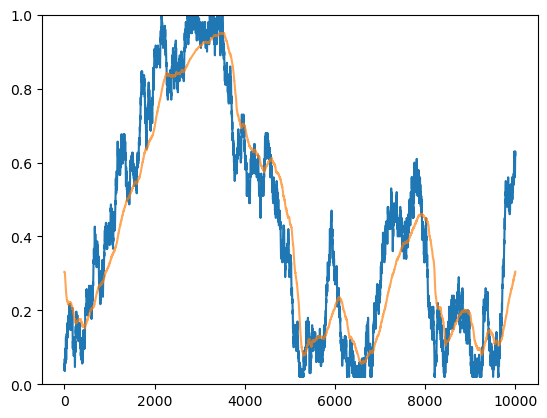

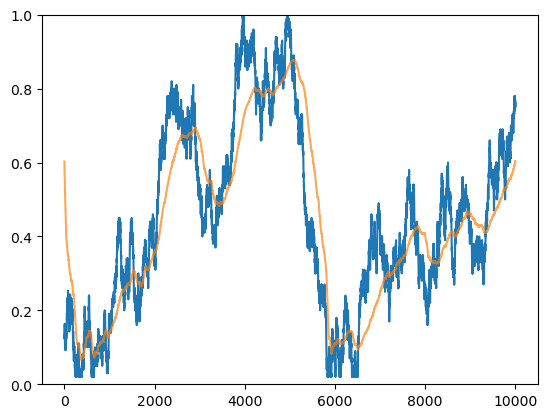

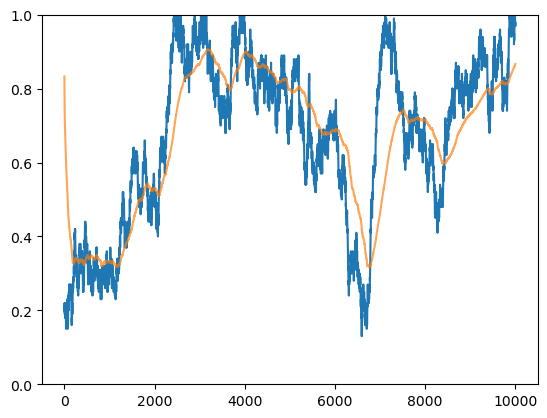

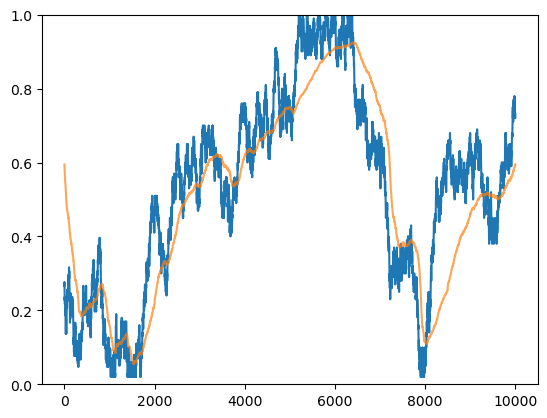

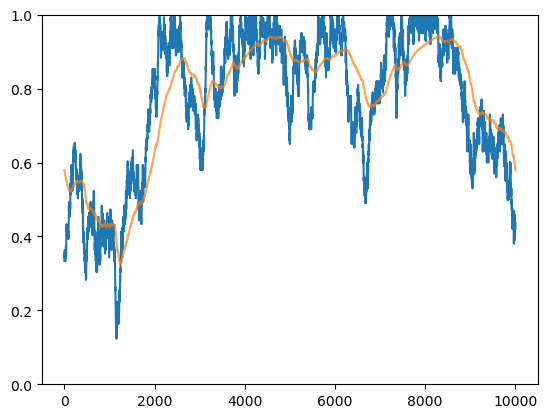

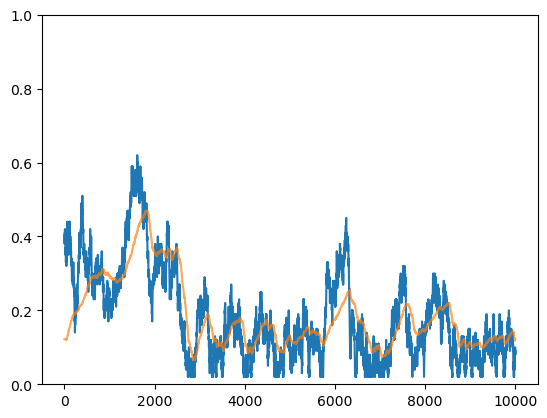

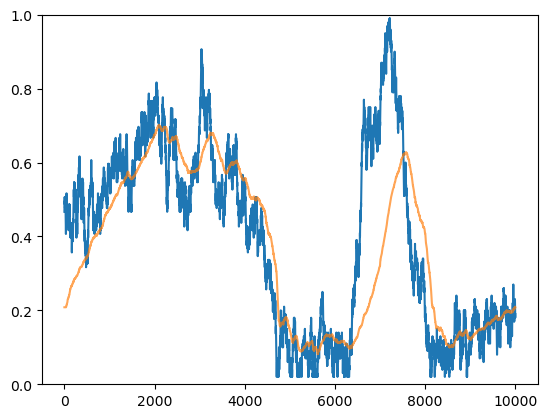

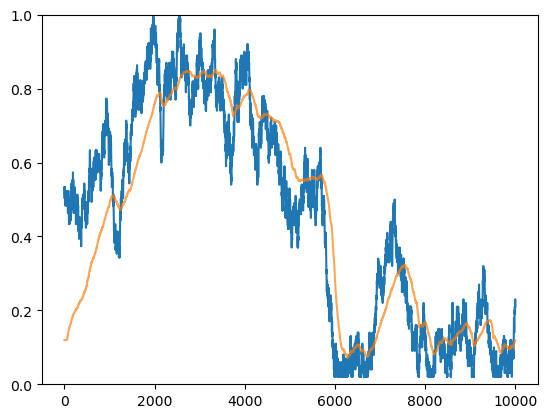

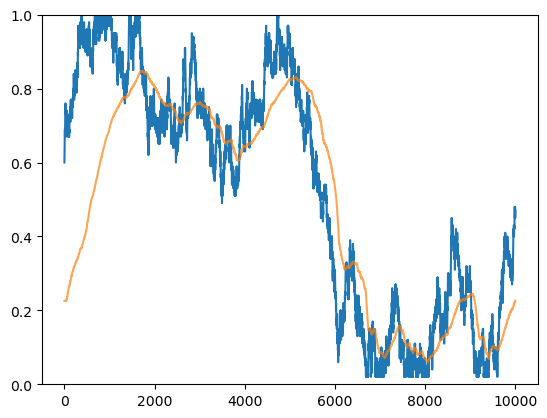

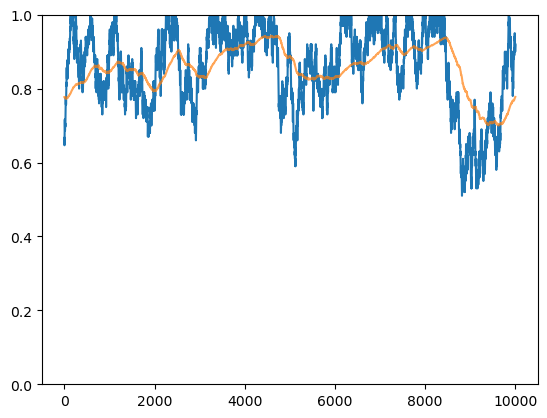

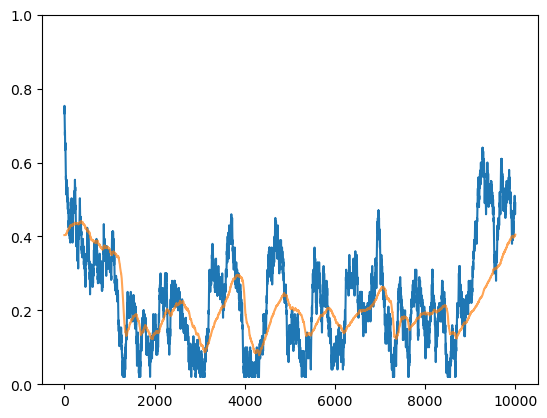

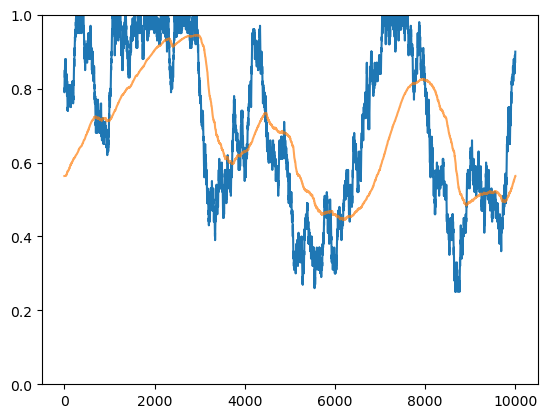

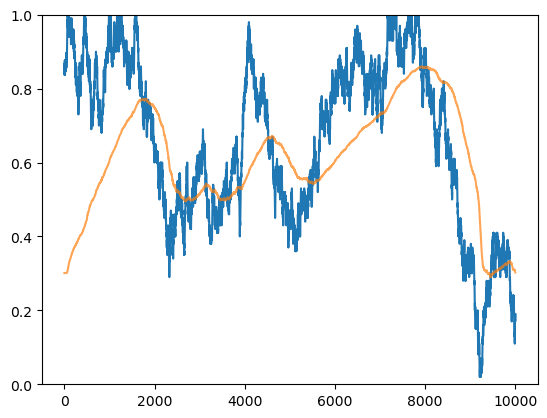

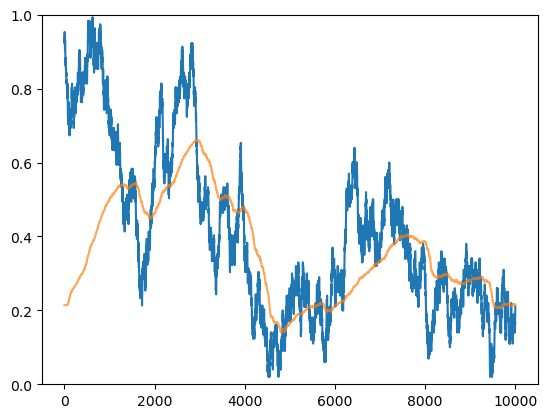

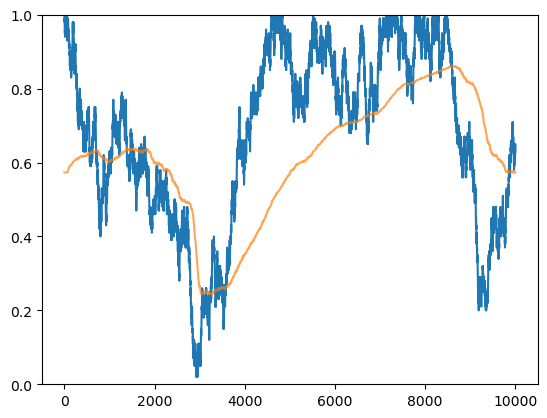

In [22]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7)
    plt.ylim([0,1])

# Scheduling Algorithm 4: Whittle's Index Policy

In [23]:
# Simulation parameters
G = 100
K_opt = 500 # Each K_opt slots, the algorithm will repeat the optimization using the current estimates of p_i
zeta = 0.05 # Averaging parameter. Need to establish which value works best, or could test across different values

In [24]:
J_avg_exp = 0
x_max_norm = 0
p_i_est_avg = np.zeros((M,K))

# Repeat simulation
for z in range(G):
    # Initialize transmission matrix that indiciates which node has an arrival in which slot
    d_i_k = np.zeros((M,K))
    
    # Initialize AoI and throughput debt vectors
    h_i = np.ones(M)
    x_i = np.zeros(M)

    # Generate outcome matrix that indicates whether transmission is successful in each time slot, assuming it is the selected time slot
    o_i_k = stats.bernoulli.rvs(p=p_i_k, size=(M,K))

    # Initialize estimates of p_i
    p_i_est = p_i#0.5*np.ones(M)

    # For each optimization horizon
    for opt_hor in range(int(K/K_opt)):
        # Throughput requirements for optimization
        tp_sum = np.sum(q_i/p_i_est)
        
        # Check whether q is a feasible set of minimum throughput requirements
        q_i_opt = q_i
        if tp_sum > 1:
            # If not, best we can do is solve the optimization problem with lower throughput requirements
            q_i_opt /= tp_sum

        # Solve optimization
        chi_i = alpha_i*p_i_est*((1/q_i_opt)**2 - (1/p_i_est - 1/2)**2)/2
        C_test = np.max(chi_i)
        phi_i_inv_test = p_i_est*np.sqrt(2*np.where(chi_i < C_test, chi_i, C_test) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
        S_test = np.sum(1/phi_i_inv_test)

        while S_test < 1:
            C = C_test
            phi_i_inv = phi_i_inv_test
            S = S_test

            C_test /= 2
            phi_i_inv_test = p_i_est*np.sqrt(2*np.where(chi_i < C_test, chi_i, C_test) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
            S_test = np.sum(1/phi_i_inv_test)
        
        # More exact optimization starting from value from previous loop
        while S < 1:
            C -= 0.1
            phi_i_inv = p_i_est*np.sqrt(2*np.where(chi_i < C, chi_i, C) / (alpha_i*p_i_est) + (1/p_i_est - 1/2)**2)
            S = np.sum(1/phi_i_inv)
            
        C_star = C
        chi_i_star = np.where(chi_i < C_star, chi_i, C_star)
        theta_i = C_star - chi_i_star
        
        # Loop over slots
        for k in range(K_opt):
            # Select node according to policy
            C_i_h_i = 0.5*alpha_i*p_i_est*(h_i**2 + (2/p_i_est)*h_i - h_i) + theta_i
            i_sel_idx = np.argmax(C_i_h_i)
            
            # Update transmission matrix based on whether transmission was successful or not
            arrival_successful = o_i_k[i_sel_idx, k + opt_hor*K_opt]
            d_i_k[i_sel_idx, k + opt_hor*K_opt] = arrival_successful

            # Calculate weighted sum AoI
            J_avg_exp += np.sum(alpha_i * h_i)
            
            # Update AoI and throughput debt vectors
            h_i += 1
            if arrival_successful: # if transmission was successful
                h_i[i_sel_idx] = 1
            x_i += q_i - d_i_k[:, k]

            # Update estimate for the scheduled node
            p_i_est[i_sel_idx] = zeta*arrival_successful + (1-zeta)*p_i_est[i_sel_idx]
            p_i_est_avg[:, k + opt_hor*K_opt] += p_i_est

    # Calculate max normalized throughput debt
    x_max_norm += np.max(np.where(x_i > 0, x_i, 0) / (K*q_i))
    
J_avg_exp /= (G*K*M)
x_max_norm /= G
p_i_est_avg /= G

In [25]:
J_avg_exp

13.761850213334789

In [26]:
x_max_norm

0.0

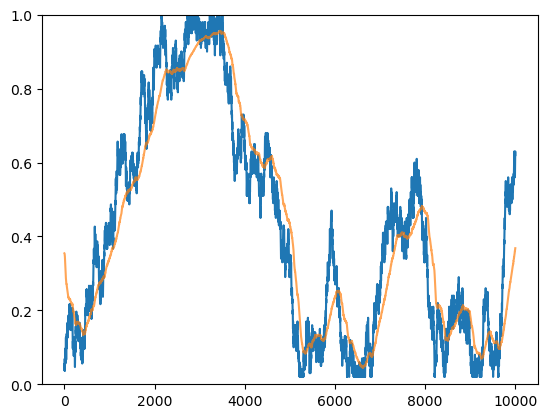

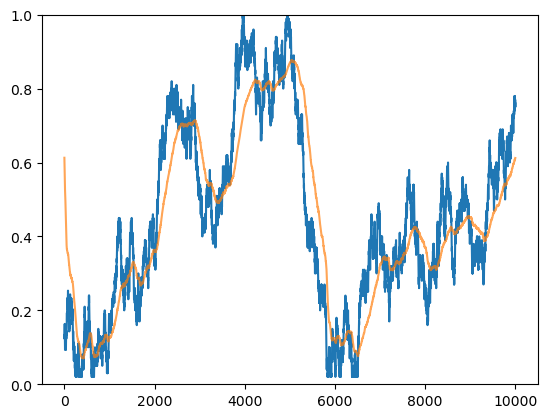

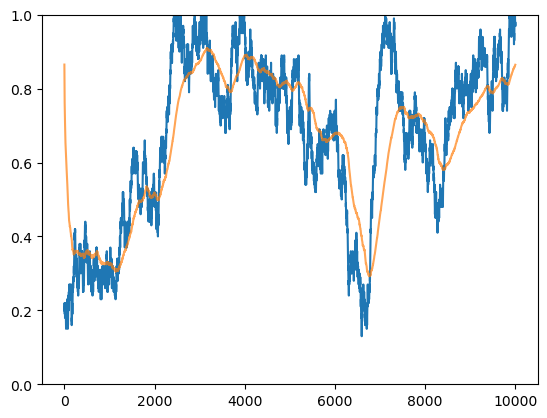

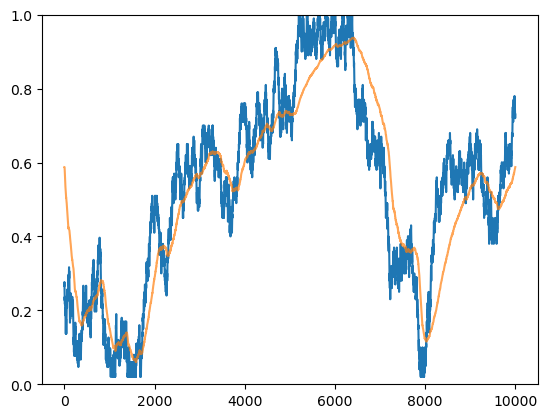

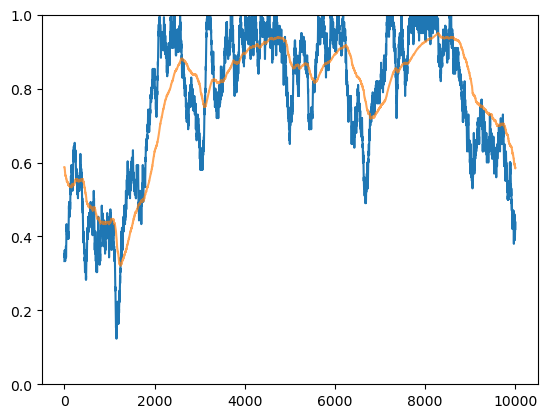

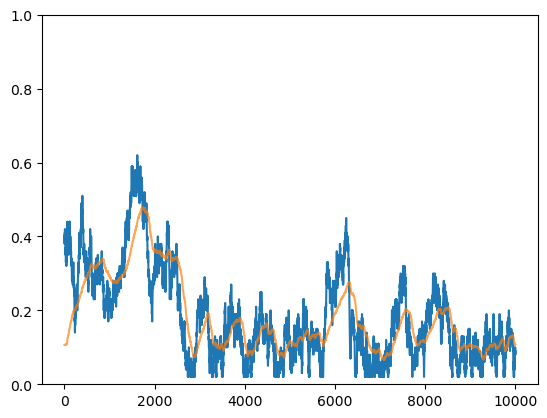

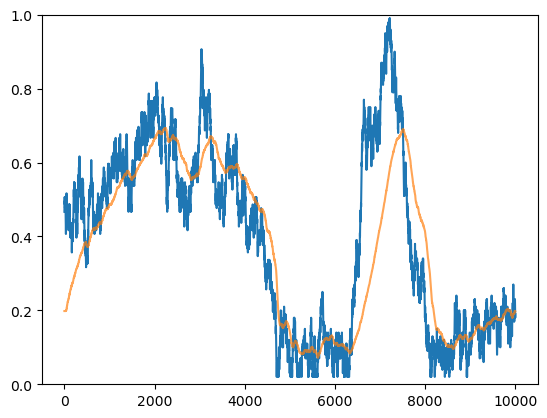

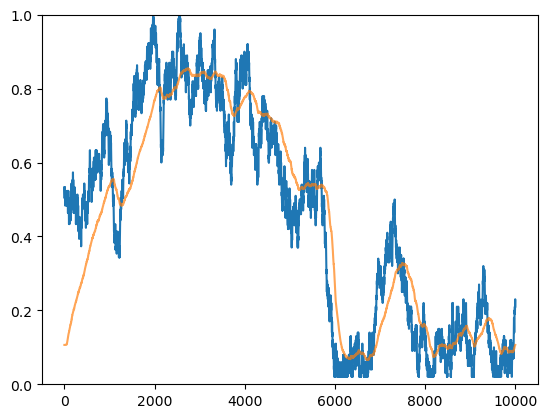

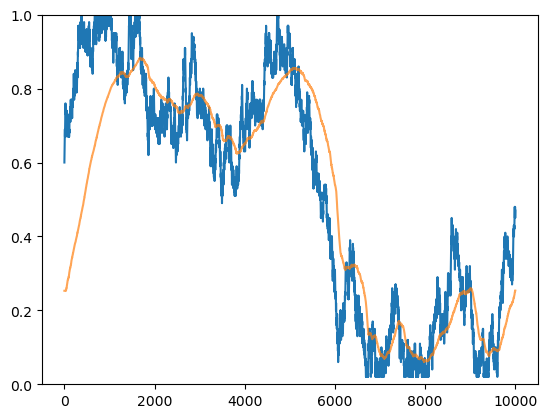

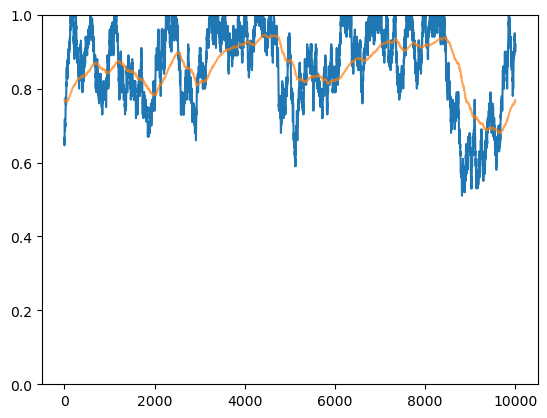

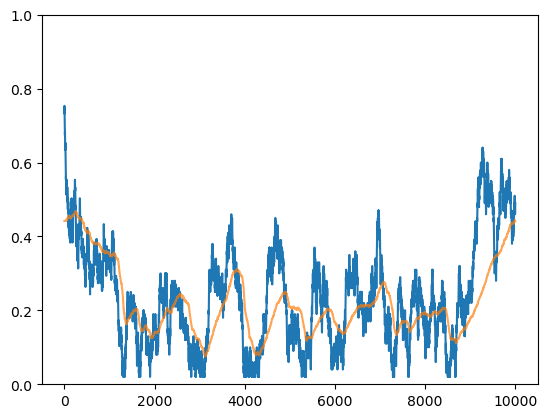

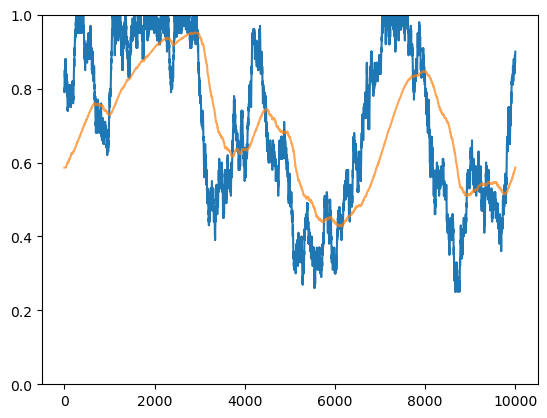

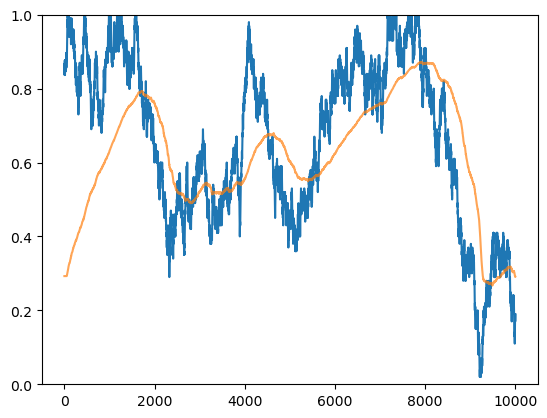

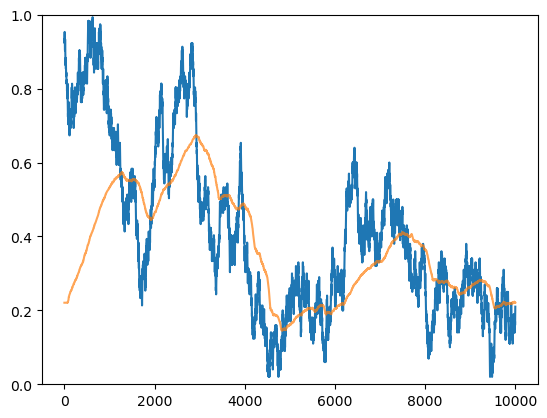

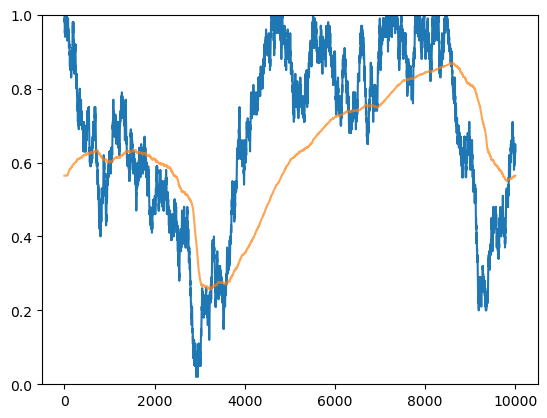

In [27]:
for src in range(M):
    plt.figure()
    plt.plot(np.arange(1,K+1), p_i_k[src, :])
    plt.plot(np.arange(1,K+1), p_i_est_avg[src, :], alpha=0.7)
    plt.ylim([0,1])